<a href="https://colab.research.google.com/github/RonnyGuevara/Machine-Learning/blob/main/TP2/TP2_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Práctica 2:  Estadística paramétrica y curva ROC

##Presentado por: Ronny Guevara

## Objetivo General
Desarrollar aplicativos que permitan dar solvencia a los problemas propuestos en la materia.
## Objetivos Específicos
*   Analizar estadisticamente el comportamiento de los valores descritos en las dataset propuestas.
*   Mediante el umbral proponer un clasificador de mínimo error utilizando la curva ROC.
*   Visualización de resultados

Problema
*   Dados los datasets de la situación epidemiológica y sanitaria de Bahía Blanca en los ultimos meses (https://datos.bahia.gob.ar/dataset?groups=covid19), responder las siguientes interrogantes: 

*   ¿Hay variables que puedan ser razonablemente consideradas normales?
*   ¿Hay variables que tienen un comportamiento sospechoso?

*   Generar un dataset (dos conjuntos Gaussianos con diferente media y DS, N=50 C7U, uno con etiqueta A y otro con etiqueta B. Realizar las siguientes acciones:

*   Utilizar la curva ROC para proponer un umbral para un clasificador por mínimo error
*   Evaluar alguno de los parámetros de calidad (exactitud, precisión, f-measure)
*   Recalcular para algunas variantes (cambio de valor umbral, cambiando la media de los grupos, etc)
*   ¿Como se podría hacer no supervisado al proceso?






###Solución
Se plantea posibles soluciones, para el primer problema ese desarrolla un aplicativo que permita al usuario visualizar los datos epidemiológicos como DataFrame para posterior representarlas mediante gráficas. Mediante visualización verificar si alguna variable tiende a un comportamiento sospechoso.
Para dar solución al segundo problema, se desarrollaa un aplicativo 

In [67]:
import numpy as np
from itertools import cycle

import requests
import pandas as pd
import json
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [68]:
def read_web_bahia(url = 'https://gobiernoabierto.bahia.gob.ar/WS/3032'):

    res = requests.get(url)
    soup = BeautifulSoup(res.content, "lxml")
    s = soup.select('html')[0].text.strip('jQuery1720724027235122559_1542743885014(').strip(')')
    s = s.replace('null','"placeholder"')
    data= json.loads(s)
    data = json_normalize(data)
    df = pd.DataFrame(data)
    print(df)
    return df

In [69]:
covid_cases_Bahia_url = 'https://gobiernoabierto.bahia.gob.ar/WS/3032'
covid_cases_Bahia_df = read_web_bahia(covid_cases_Bahia_url)
covid_cases_Bahia_df['fecha'] = pd.to_datetime(covid_cases_Bahia_df['fecha'])
#covid_cases_Bahia_Bahia_df.describe()
covid_cases_Bahia_df

          fecha  confirmados  activos  recuperados  decesos  descartados  \
0    2020-03-19            0        0            0        0            2   
1    2020-03-20            0        0            0        0            0   
2    2020-03-21            1        1            0        0            4   
3    2020-03-22            1        1            0        0            5   
4    2020-03-23            3        3            0        0            6   
..          ...          ...      ...          ...      ...          ...   
743  2022-04-01        69774      107        68620     1047            0   
744  2022-04-02        69775       98        68630     1047            0   
745  2022-04-03        69775       83        68645     1047            0   
746  2022-04-04        69798      102        68649     1047            0   
747  2022-04-05        69808       89        68672     1047            0   

     sospechosos  contencion_psicologica  monitoreo_epidemiologico  \
0              4 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,fecha,confirmados,activos,recuperados,decesos,descartados,sospechosos,contencion_psicologica,monitoreo_epidemiologico,aislamiento_por_contacto_estrecho,aprehendidos
0,2020-03-19,0,0,0,0,2,4,0,380,0,0
1,2020-03-20,0,0,0,0,0,3,0,405,0,31
2,2020-03-21,1,1,0,0,4,2,0,502,8,73
3,2020-03-22,1,1,0,0,5,1,0,455,0,71
4,2020-03-23,3,3,0,0,6,0,0,439,0,64
...,...,...,...,...,...,...,...,...,...,...,...
743,2022-04-01,69774,107,68620,1047,0,0,0,280,0,0
744,2022-04-02,69775,98,68630,1047,0,0,0,280,0,0
745,2022-04-03,69775,83,68645,1047,0,0,0,280,0,0
746,2022-04-04,69798,102,68649,1047,0,0,0,280,0,0


In [70]:
covid_beds_Bahia_url = 'https://gobiernoabierto.bahia.gob.ar/WS/3028'
covid_beds_Bahia_df = read_web_bahia(covid_beds_Bahia_url) 
covid_beds_Bahia_df['fecha'] = pd.to_datetime(covid_beds_Bahia_df['fecha'])
covid_beds_Bahia_df.describe()
covid_beds_Bahia_df

      id       fecha  intensivostotal  intensivosocupadas  \
0    336  2022-04-06               74                  34   
1    335  2022-04-05               74                  30   
2    334  2022-04-04               74                  35   
3    333  2022-04-03               74                  34   
4    332  2022-04-02               73                  34   
..   ...         ...              ...                 ...   
327    5  2021-05-18               72                  49   
328    4  2021-05-17               81                  55   
329    3  2021-05-16              100                  69   
330    2  2021-05-15              107                  77   
331    1  2021-05-14              107                  79   

     intensivosconfirmados  intensivossospechosos  intermediostotal  \
0                        0                      0               316   
1                        0                      0               316   
2                        0                      0     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,id,fecha,intensivostotal,intensivosocupadas,intensivosconfirmados,intensivossospechosos,intermediostotal,intermediosocupadas,intermediosconfirmados,intermediossospechosos,minimostotal,minimosocupadas,minimosconfirmados,minimossospechosos,ucmasedes,ucmatotal,ucmaocupadas
0,336,2022-04-06,74,34,0,0,316,158,1,7,440,197,3,1,2,80,0
1,335,2022-04-05,74,30,0,0,316,147,1,4,439,204,3,1,2,80,0
2,334,2022-04-04,74,35,0,0,316,127,0,3,441,155,3,0,2,80,0
3,333,2022-04-03,74,34,0,0,316,122,0,3,441,152,3,0,2,80,0
4,332,2022-04-02,73,34,0,0,316,134,0,5,441,175,3,3,2,80,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,5,2021-05-18,72,49,32,0,217,134,47,6,330,209,54,8,3,102,11
328,4,2021-05-17,81,55,36,1,208,128,37,11,330,197,54,11,3,102,11
329,3,2021-05-16,100,69,44,1,191,118,33,8,331,196,61,9,3,102,11
330,2,2021-05-15,107,77,50,1,185,111,25,6,337,193,58,8,3,102,11


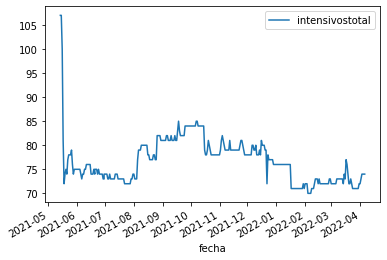

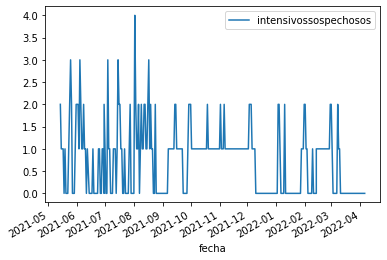

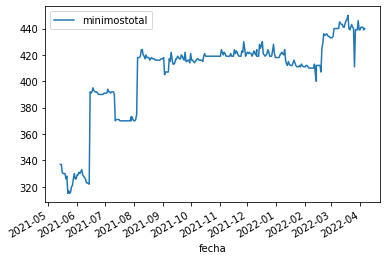

In [71]:
covid_beds_Bahia_df.plot.line(y="intensivostotal", x="fecha")
covid_beds_Bahia_df.plot.line(y="intensivossospechosos", x="fecha")
covid_beds_Bahia_df.plot.line(y="minimostotal", x="fecha")

In [72]:
df = pd.merge(covid_cases_Bahia_df, covid_beds_Bahia_df,  how='inner', on=["fecha"])
df

,fecha,confirmados,activos,recuperados,decesos,descartados,sospechosos,contencion_psicologica,monitoreo_epidemiologico,aislamiento_por_contacto_estrecho,...,intermediosocupadas,intermediosconfirmados,intermediossospechosos,minimostotal,minimosocupadas,minimosconfirmados,minimossospechosos,ucmasedes,ucmatotal,ucmaocupadas
0,2021-05-14,25762,3126,22116,520,0,0,0,1106,0,...,122,24,10,337,202,56,9,3,102,14
1,2021-05-15,25894,3043,22328,523,0,0,0,1106,0,...,111,25,6,337,193,58,8,3,102,11
2,2021-05-16,26102,2943,22634,525,0,0,0,1101,0,...,118,33,8,331,196,61,9,3,102,11
3,2021-05-17,26648,3245,22877,526,0,0,0,1101,0,...,128,37,11,330,197,54,11,3,102,11
4,2021-05-18,26967,3291,23141,535,0,0,0,1099,0,...,134,47,6,330,209,54,8,3,102,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,2022-04-01,69774,107,68620,1047,0,0,0,280,0,...,139,0,6,439,184,3,1,2,80,0
327,2022-04-02,69775,98,68630,1047,0,0,0,280,0,...,134,0,5,441,175,3,3,2,80,0
328,2022-04-03,69775,83,68645,1047,0,0,0,280,0,...,122,0,3,441,152,3,0,2,80,0
329,2022-04-04,69798,102,68649,1047,0,0,0,280,0,...,127,0,3,441,155,3,0,2,80,0


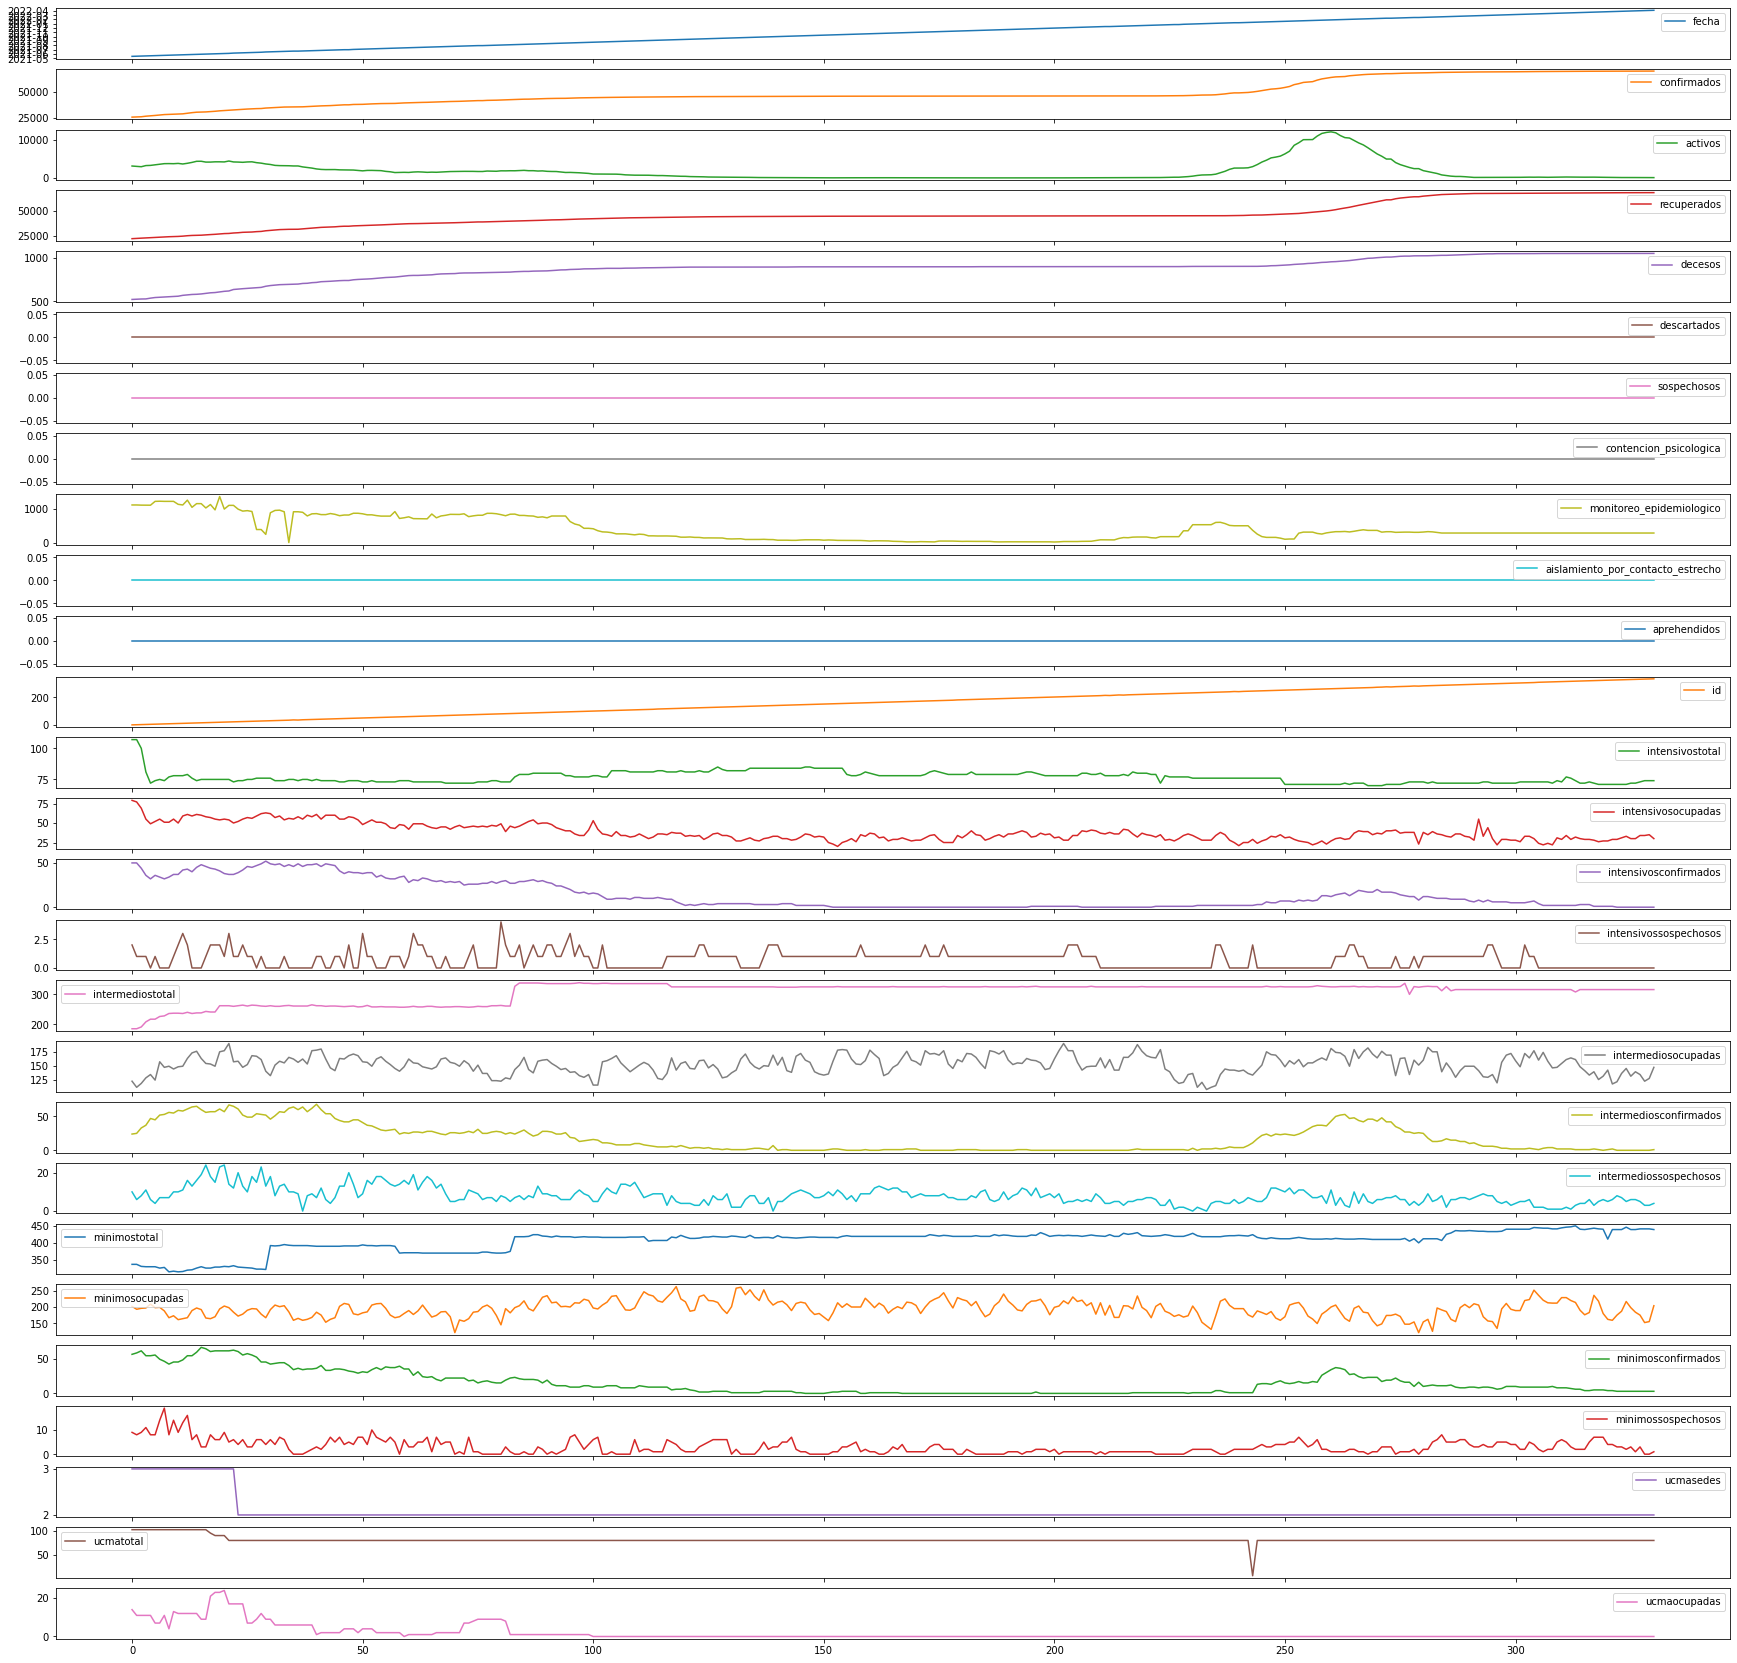

In [73]:
import numpy as np
import matplotlib.pyplot as plt
# df.set_index('fecha', inplace=True)
df.plot(label='fecha', subplots=True,figsize=(30,30))
plt.show()
#falta reescalar las y axis.

EJERCICIO 2

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
dataset1=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ALTURAHOMBRES.xlsx')
dataset2=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ALTURAMUJERES.xlsx')

In [76]:
dataset1=pd.DataFrame(dataset1)
dataset2=pd.DataFrame(dataset2)
dataset1.describe()
 #La función permite obtener una descripción de la DATASET
#dataset1.plot.bar()
#dataset2.plot.bar()

,Altura
count,50.00000
mean,172.50000
std,4.26782
min,165.00000
25%,169.00000
50%,172.00000
75%,175.75000
max,180.00000


In [77]:
dataset2.describe()

,Altura
count,50.000000
mean,159.220000
std,5.448422
min,150.000000
25%,155.000000
50%,159.000000
75%,164.000000
max,168.000000


In [78]:
#dataset1.plot.scatter(y='Altura', x='Altura')
#dataset2.plot.scatter(y='Altura', x='Altura')

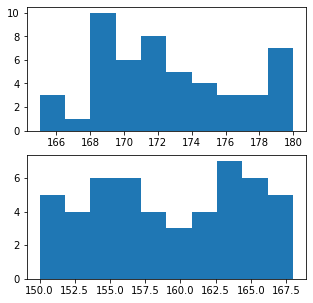

In [79]:
y=dataset1['Altura']
num_bins = 10
z=dataset2['Altura']
num_bins2 = 10

fig, axs = plt.subplots(2, 1, figsize=(5, 5))
axs[0].hist(y, num_bins)
axs[1].hist(z, num_bins2)
plt.show()

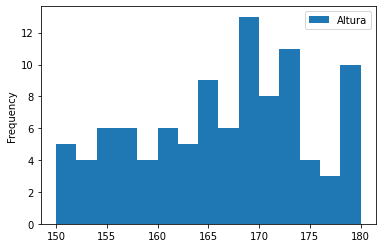

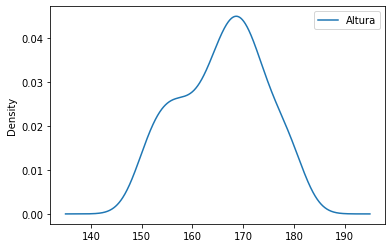

In [80]:
df = pd.concat([dataset1, dataset2])
df.plot.hist(bins=15)
df.plot.density()

In [81]:
df_ord = df
df_ord.sort_values('Altura', inplace=True, ignore_index=True)
df_ord

,Etiqueta,Altura
0,B,150.0
1,B,151.0
2,B,151.0
3,B,151.0
4,B,151.0
...,...,...
95,A,179.0
96,A,180.0
97,A,180.0
98,A,180.0


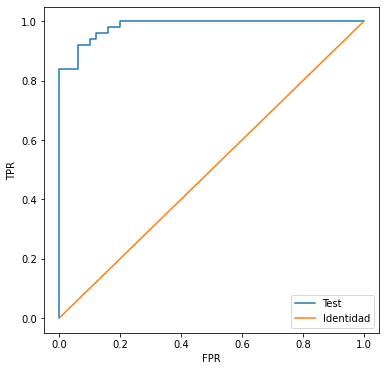

In [85]:
x_list, y_list = ([], [])
x_list.append(0)
y_list.append(0)

x, y = (0, 0)

for i in range(100):
    if df_ord.iloc[-(1+i), 0] == 'A':
        y += 1/50
    else:
        x += 1/50
    x_list.append(x)
    y_list.append(y)


plt.figure(1, (6,6))
plt.plot(x_list, y_list, [0,1], [0,1])
plt.xlabel("FPR")
plt.ylabel("TPR")
#plt.grid()
plt.legend(['Test', 'Identidad'])

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
data_X, cls_lab = make_classification(n_samples=2100, n_classes=2, weights=[1,1], random_state=2)
train_X, test_X, train_y, test_y = train_test_split(data_X, cls_lab, test_size=0.5, random_state=2)
model =RandomForestClassifier()
model.fit(train_X, train_y)

prob = model.predict_proba(test_X)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(y_list, prob)
plot_roc_curve(fper, tper)

ValueError: ignored